# ML Model for Rusty Bargain Used Cars Service 
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. For this project, we built the model to determine the value. 

Rusty Bargain was interested in the following:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

For this project, we trained different models with various hyperparameters (some models had various implementations of gradient boosting.) The main point of this step was to compare gradient boosting methods with random forest, decision tree, and linear regression. Similarly, we analyzed the speed and quality of the models and used the RMSE metric to evaluate the models. Since the Linear regression model is not very good for hyperparameter tuning, we used it as a sanity check of other methods. Somethign we kept in mind is that if gradient boosting performs worse than linear regression, something definitely went wrong.

## Libraries used for Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import lightgbm as lbt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Data preparation
The CV provided by Rusty Bargain was saved in the __data__ variable as a pandas DataFrame. The dataframe contained a total of 16 columns and 354369 entried, each representing information about an used vehicle. Below is a description of the columns: 
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user
- Price — price (Euro)

In [2]:
data = pd.read_csv('/datasets/car_data.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

The columns that contained missing values include: 
- VehicleType
- Gearbox
- Model 
- FuelType
- NotRepaired



### fixing column names

In this section, we changed the the column names to all lowercase.

In [4]:
data.columns = data.columns.str.lower()
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

### datecrawled column 
In the section, we checked for the data type, errors in data, missing values or anomalies in each of the columns. The __datecrawled__ column did not have any missing values or anomalies. However, the date type was changed to datetime64[ns]. 

In [5]:
data['datecrawled'] = pd.to_datetime(data['datecrawled'], format = '%d/%m/%Y %H:%M')
data.datecrawled

0        2016-03-24 11:52:00
1        2016-03-24 10:58:00
2        2016-03-14 12:52:00
3        2016-03-17 16:54:00
4        2016-03-31 17:25:00
                 ...        
354364   2016-03-21 09:50:00
354365   2016-03-14 17:48:00
354366   2016-03-05 19:56:00
354367   2016-03-19 18:57:00
354368   2016-03-20 19:41:00
Name: datecrawled, Length: 354369, dtype: datetime64[ns]

In [6]:
data.query('datecrawled.isna()')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


However, this column does not act as a variable that affects the price of a vehicle. Therefore, it was dropped. 

In [7]:
data = data.drop('datecrawled', axis=1)
data

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


### price column

The price column did not present any errors in date (e.g. negative values) or missing values. Below is the distribution of the price values. 

In [8]:
data.query('price.isna()')

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen


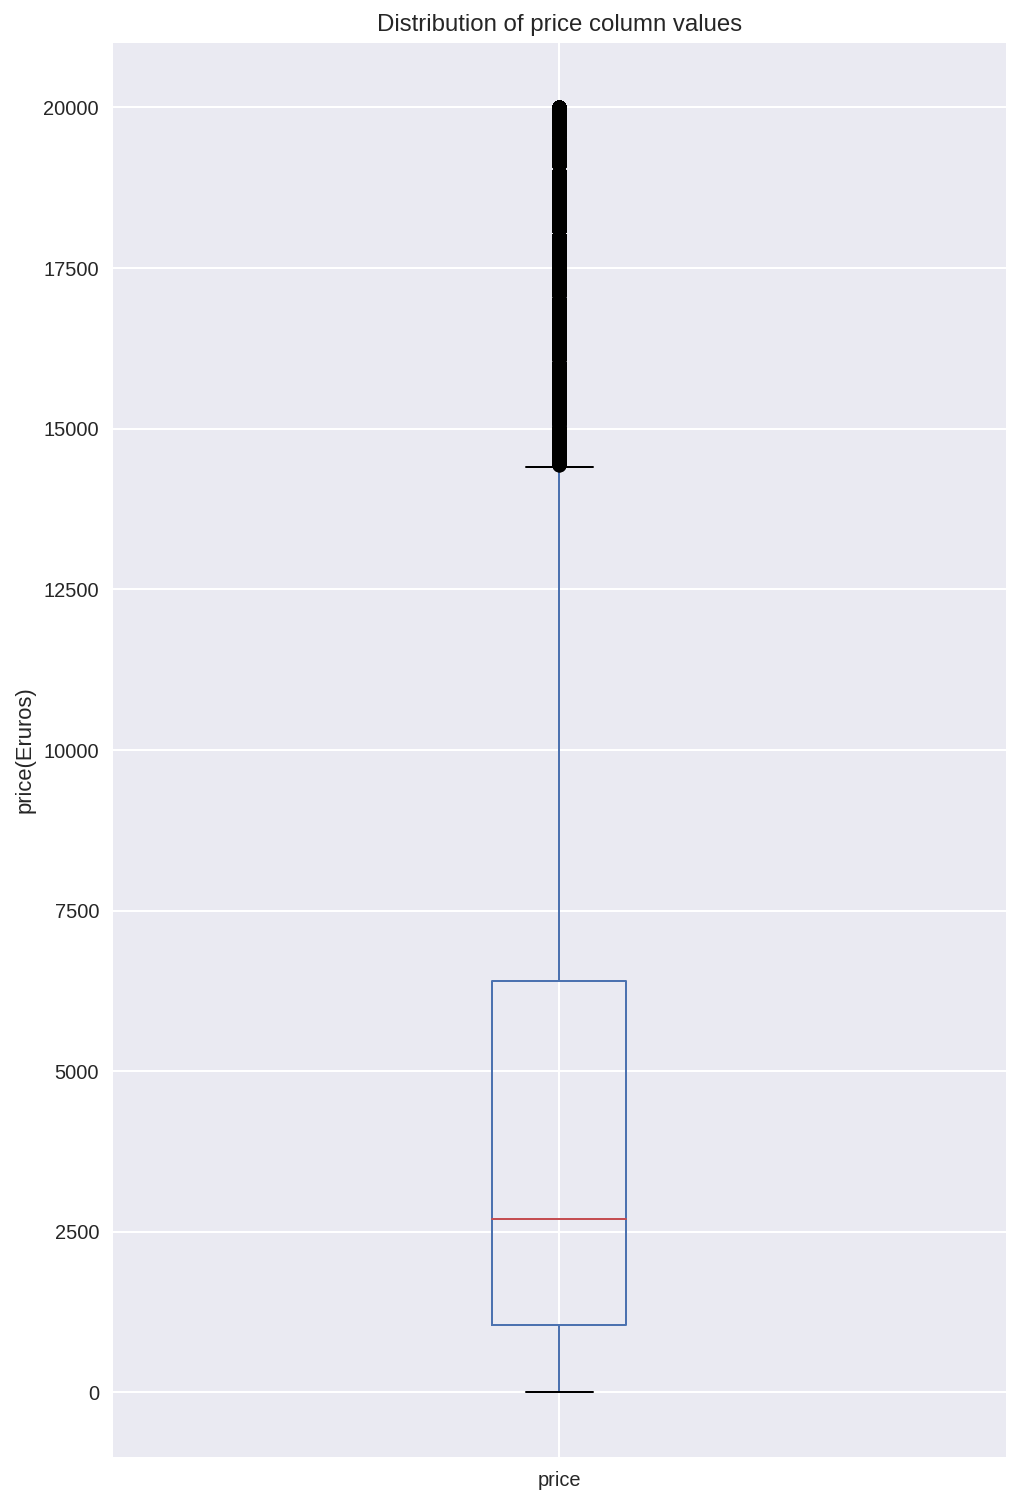

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [9]:
data.price.plot(kind='box', figsize=(8,13))
plt.ylabel('price(Eruros)')
plt.title('Distribution of price column values')
plt.show()
data.price.describe()

### vehicletype column
The __vehicletype__ column had a total of 37490 rows with missing values, which accounted for 10.6% of the data for this column. The missing values for this column were replaced with 'unknown' value to maintain a data type of object.  

In [10]:
print(len(data.query('vehicletype.isna()'))/len(data) * 100)
data.query('vehicletype.isna()')

10.57936783409384


,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,0,38871,01/04/2016 12:46
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,23/03/2016 00:00,0,49716,31/03/2016 01:16
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,10/03/2016 00:00,0,31139,16/03/2016 09:16
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,29/03/2016 00:00,0,37075,29/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,0,61169,08/03/2016 21:28
354351,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,0,51371,13/03/2016 01:44
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42


In [11]:
data.vehicletype.fillna('unknown', inplace=True)
print(data.vehicletype.unique())
data.info()

['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicletype        354369 non-null  object
 2   registrationyear   354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   mileage            354369 non-null  int64 
 7   registrationmonth  354369 non-null  int64 
 8   fueltype           321474 non-null  object
 9   brand              354369 non-null  object
 10  notrepaired        283215 non-null  object
 11  datecreated        354369 non-null  object
 12  numberofpictures   354369 non-null  int64 
 13  postalcode         354369 non-null  int64 
 14  lastseen           354369 non-null  o

### registrationyear column

The __registration_year__ column did not present any mising values. The data type was changed to int64 data type. 

In [12]:
data.registrationyear.describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

In [13]:
data['registrationyear'] = data['registrationyear'].astype('int')
print(data.registrationyear.head(5))


0    1993
1    2011
2    2004
3    2001
4    2008
Name: registrationyear, dtype: int64


In [14]:
#errors in column 
data.query('registrationyear < 1903 or registrationyear > 2022')

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
622,0,unknown,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,16/03/2016 00:00,0,44628,20/03/2016 16:44
12946,49,unknown,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,29/03/2016 00:00,0,74523,06/04/2016 04:16
15147,0,unknown,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,13/03/2016 00:00,0,32689,21/03/2016 23:46
15870,1700,unknown,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,02/04/2016 00:00,0,33649,06/04/2016 09:46
16062,190,unknown,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,29/03/2016 00:00,0,47166,06/04/2016 10:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340548,0,unknown,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN,02/04/2016 00:00,0,96465,04/04/2016 15:17
340759,700,unknown,1600,manual,1600,a3,150000,4,petrol,audi,no,04/04/2016 00:00,0,86343,05/04/2016 06:44
341791,1,unknown,3000,NaN,0,zafira,5000,0,NaN,opel,NaN,28/03/2016 00:00,0,26624,02/04/2016 22:17
348830,1,unknown,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,21/03/2016 00:00,0,41472,05/04/2016 14:18


### gearbox column

The __gearbox__ column had a total 19833 rows that contained missing values. These NaN values were replaced with 'unknown' value to maintain an object data type for the column. 

In [15]:
data.query('gearbox.isna()')

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,0,24148,19/03/2016 08:46
16,300,unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,0,38871,01/04/2016 12:46
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,15/03/2016 00:00,0,44145,17/03/2016 18:17
37,1500,unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,28/03/2016 00:00,0,46483,30/03/2016 09:18
40,0,unknown,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,26/03/2016 00:00,0,56412,27/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,16/03/2016 00:00,0,12057,17/03/2016 12:17
354305,3500,unknown,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,03/04/2016 00:00,0,74579,05/04/2016 12:44
354329,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,30/03/2016 00:00,0,25436,07/04/2016 13:50
354338,180,unknown,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,0,41470,06/04/2016 14:18


In [16]:
data.gearbox.fillna('unknown', inplace=True)
data.gearbox.unique()

array(['manual', 'auto', 'unknown'], dtype=object)

### power column

The power column did not present any missing values; however, according to AutoSnout.com, the vehicles' horsepower ranges up to  1,888 hp. Therefore, the values that were greater than this value were removed from the column. 

In [17]:
data.power.sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [18]:
data.drop(data.query('power > 1888').index, inplace=True)
data.reset_index(drop=True, inplace =True)


count    354225.000000
mean        107.208743
std          70.044310
min           0.000000
25%          69.000000
50%         105.000000
75%         142.000000
max        1870.000000
Name: power, dtype: float64

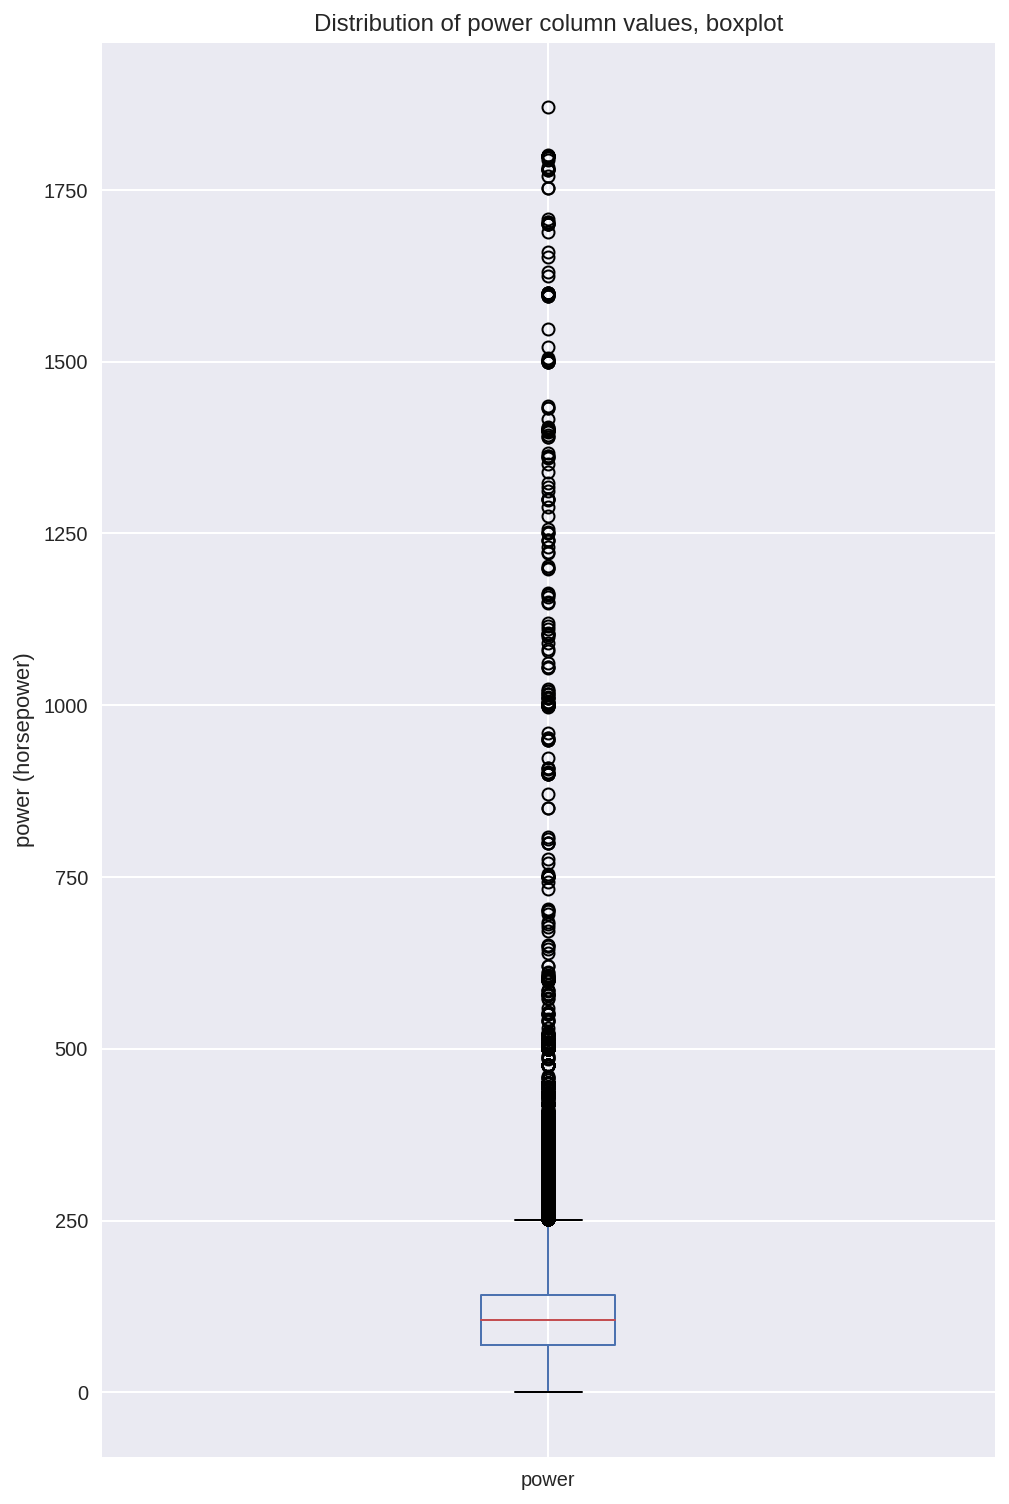

In [19]:
data.power.plot(kind='box',figsize=(8,13))
plt.ylabel('power (horsepower)')
plt.title('Distribution of power column values, boxplot')
data.power.describe()


### model column

The __model__ colum had a total of 19,630 rows with missing values. The missing values were replaced with 'unknown' labels to maintain an object data type in the column. 

In [20]:
data.query('model.isna()')

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,29/03/2016 00:00,0,53721,06/04/2016 01:44
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,03/04/2016 00:00,0,45665,05/04/2016 11:47
115,0,small,1999,unknown,0,NaN,5000,0,petrol,volkswagen,NaN,20/03/2016 00:00,0,37520,07/04/2016 02:45
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,27/03/2016 00:00,0,38709,05/04/2016 20:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354101,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,07/03/2016 00:00,0,55743,12/03/2016 21:45
354177,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,15/03/2016 00:00,0,91186,17/03/2016 08:16
354194,180,unknown,1995,unknown,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,0,41470,06/04/2016 14:18
354207,1900,unknown,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16


In [21]:
data.model.fillna('unknown', inplace=True)
print(sorted(data.model.unique()))

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'freelander', 'fusion', 

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354225 entries, 0 to 354224
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354225 non-null  int64 
 1   vehicletype        354225 non-null  object
 2   registrationyear   354225 non-null  int64 
 3   gearbox            354225 non-null  object
 4   power              354225 non-null  int64 
 5   model              354225 non-null  object
 6   mileage            354225 non-null  int64 
 7   registrationmonth  354225 non-null  int64 
 8   fueltype           321360 non-null  object
 9   brand              354225 non-null  object
 10  notrepaired        283129 non-null  object
 11  datecreated        354225 non-null  object
 12  numberofpictures   354225 non-null  int64 
 13  postalcode         354225 non-null  int64 
 14  lastseen           354225 non-null  object
dtypes: int64(7), object(8)
memory usage: 40.5+ MB


### mileage column

The __mileage__ column did not have any missing values or errors in data. The int64 data type was correct for this column. 

In [23]:
data.mileage.unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

### registrationmonth

The __registrationmonth__ column did not present any missing values or errors in the data. The data type int64 was correct. 

In [24]:
data.registrationmonth.unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

### fueltype

The __fueltype__ column had a total of 23,767 missing values in the column. The missing values were replaced with 'unknown' values to maintain a data type of object in the column. 

In [25]:
data.query('fueltype.isna()')

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,21/03/2016 00:00,0,90762,23/03/2016 02:50
26,5555,unknown,2017,manual,125,c4,125000,4,NaN,citroen,no,10/03/2016 00:00,0,31139,16/03/2016 09:16
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,11/03/2016 00:00,0,2943,07/04/2016 03:46
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,30/03/2016 00:00,0,33649,03/04/2016 11:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354195,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,20/03/2016 00:00,0,53947,26/03/2016 21:18
354202,2600,unknown,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,0,61169,08/03/2016 21:28
354207,1900,unknown,2000,manual,110,unknown,150000,7,NaN,volkswagen,no,11/03/2016 00:00,0,87700,12/03/2016 14:16
354217,5250,unknown,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,0,51371,13/03/2016 01:44


In [26]:
data.fueltype.fillna('unknown', inplace = True)
data.fueltype.unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

### brand column

The __brand__ column did not present any missing values or errors in the data. The data type object was correct for this column.

In [27]:
data.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

### notrepaired column
The __notrepaired__ column had a total of 71,007 missing values in the column. The missing values were replaced with an 'unknown' values to maintain an object data type in the column. 

In [28]:
data.query('notrepaired.isna()')

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17
12,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,15/03/2016 00:00,0,37269,01/04/2016 13:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,16/03/2016 00:00,0,56472,18/03/2016 11:30
354212,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,04/04/2016 00:00,0,88477,06/04/2016 12:44
354213,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,09/03/2016 00:00,0,18246,04/04/2016 08:15
354221,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46


In [29]:
data.notrepaired.fillna('unknown', inplace = True)
data.notrepaired.unique()

array(['unknown', 'yes', 'no'], dtype=object)

### datecreated column
The __datecreated__ column did not present any missing values and the data type was changed to datetime64[ns]. 

In [30]:
data['datecreated'] = pd.to_datetime(data['datecreated'], format = '%d/%m/%Y %H:%M')
data.datecreated.head(10)

0   2016-03-24
1   2016-03-24
2   2016-03-14
3   2016-03-17
4   2016-03-31
5   2016-04-04
6   2016-04-01
7   2016-03-21
8   2016-04-04
9   2016-03-17
Name: datecreated, dtype: datetime64[ns]

However, this column does not act as a variable that affects the price of a vehicle. Therefore, it was dropped. 

In [31]:
data = data.drop('datecreated', axis=1)
data

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,lastseen
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,0,70435,07/04/2016 03:16
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,0,66954,07/04/2016 01:46
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,0,90480,05/04/2016 12:47
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074,17/03/2016 17:40
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354220,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,0,2694,21/03/2016 10:42
354221,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,0,39576,06/04/2016 00:46
354222,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,0,26135,11/03/2016 18:17
354223,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,0,87439,07/04/2016 07:15


### numberofpictures
The __numberofpictures__ column did not present any missing values or errors in the column. However, this column does not act as a variable that affects the price of a vehicle. Therefore, it was dropped. 

In [32]:
data.numberofpictures.unique()

array([0])

In [33]:
data = data.drop('numberofpictures', axis=1)
data

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,postalcode,lastseen
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,70435,07/04/2016 03:16
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954,07/04/2016 01:46
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,90480,05/04/2016 12:47
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,17/03/2016 17:40
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354220,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2694,21/03/2016 10:42
354221,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,39576,06/04/2016 00:46
354222,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135,11/03/2016 18:17
354223,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,87439,07/04/2016 07:15


### postalcode column
The __postalcode__ column did not present any missing values in the data or errors. 

In [34]:
data.postalcode.unique()

array([70435, 66954, 90480, ..., 38528, 38325, 31096])

However, this column does not act as a variable that affects the price of a vehicle. Therefore, it was dropped. 

In [35]:
data = data.drop('postalcode', axis=1)
data

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,lastseen
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,07/04/2016 03:16
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,07/04/2016 01:46
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,05/04/2016 12:47
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 17:40
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...
354220,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 10:42
354221,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown,06/04/2016 00:46
354222,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,11/03/2016 18:17
354223,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,07/04/2016 07:15


### lastseen column

The __lastseen__ column did not present any missing values or errors in the data. The data type of the column was changed to datetime64[ns]. 

In [36]:
data.lastseen

0         07/04/2016 03:16
1         07/04/2016 01:46
2         05/04/2016 12:47
3         17/03/2016 17:40
4         06/04/2016 10:17
                ...       
354220    21/03/2016 10:42
354221    06/04/2016 00:46
354222    11/03/2016 18:17
354223    07/04/2016 07:15
354224    24/03/2016 12:45
Name: lastseen, Length: 354225, dtype: object

In [37]:
data['lastseen'] = pd.to_datetime(data['lastseen'], format = '%d/%m/%Y %H:%M')
data.lastseen

0        2016-04-07 03:16:00
1        2016-04-07 01:46:00
2        2016-04-05 12:47:00
3        2016-03-17 17:40:00
4        2016-04-06 10:17:00
                 ...        
354220   2016-03-21 10:42:00
354221   2016-04-06 00:46:00
354222   2016-03-11 18:17:00
354223   2016-04-07 07:15:00
354224   2016-03-24 12:45:00
Name: lastseen, Length: 354225, dtype: datetime64[ns]

However, this column does not act as a variable that affects the price of a vehicle. Therefore, it was dropped. 

In [38]:
data = data.drop('lastseen', axis=1)
data

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354220,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354221,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown
354222,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354223,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


### data after fixing errors in column 

In [39]:
data.head(10)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354225 entries, 0 to 354224
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354225 non-null  int64 
 1   vehicletype        354225 non-null  object
 2   registrationyear   354225 non-null  int64 
 3   gearbox            354225 non-null  object
 4   power              354225 non-null  int64 
 5   model              354225 non-null  object
 6   mileage            354225 non-null  int64 
 7   registrationmonth  354225 non-null  int64 
 8   fueltype           354225 non-null  object
 9   brand              354225 non-null  object
 10  notrepaired        354225 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


## Model training

### Preparing datasets for model training
In this section, we prepated the data for training and testing of the models. The data used for the linear regression models was transfomed by means of One-Hot-Encoding. The data was saved in the variable __data_ohe__. 

For DecisionTree models, we transformed the data by means of Encoder. We used two different types of transformed data: scaled and non-scaled transformed data. 

For CatBoost and LightGBM model, we tranformed the values from the columns : `datecrawled`, `lastseen` and `datecreated` similarly to the way we transformed these same columns in __data_ohe__. 

In [41]:
#types of columns in data DataFrame
numerical_columns= data[['registrationyear', 'power', 'mileage', 'registrationmonth']]

categorical_columns = data[[
     'vehicletype', 'gearbox', 'model', 'fueltype', 
    'brand', 'notrepaired']]

target = data['price']

In [42]:
# OHE for linear regression 
categorical_ohe = pd.get_dummies(categorical_columns, drop_first = True)
data_ohe = categorical_ohe
data_ohe[['registrationyear', 'power', 'mileage', 'registrationmonth']] = numerical_columns 


In [43]:
#OrdinalEncoding, non-scaled for DecisionTree models
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(categorical_columns), columns = categorical_columns.columns)
data_ordinal[['registrationyear', 'power', 'mileage', 'registrationmonth']] = numerical_columns
data_ordinal['price'] = data['price']
data_ordinal.head(3)

,vehicletype,gearbox,model,fueltype,brand,notrepaired,registrationyear,power,mileage,registrationmonth,price
0,7.0,1.0,116.0,6.0,38.0,1.0,1993,0,150000,0,480
1,2.0,1.0,228.0,2.0,1.0,2.0,2011,190,125000,5,18300
2,6.0,0.0,117.0,2.0,14.0,1.0,2004,163,125000,8,9800


In [44]:
#OrdinalEncoding, scaled for DecisionTree models
data_ordinal_scaled = pd.DataFrame(encoder.fit_transform(categorical_columns), columns = categorical_columns.columns)
data_ordinal_scaled[['registrationyear', 'power', 'mileage', 'registrationmonth']] = numerical_columns

scaler = StandardScaler()
data_ordinal_scaled =pd.DataFrame(scaler.fit_transform(data_ordinal_scaled), columns = data_ordinal_scaled.columns)
data_ordinal_scaled['price'] = data['price']
data_ordinal_scaled

,vehicletype,gearbox,model,fueltype,brand,notrepaired,registrationyear,power,mileage,registrationmonth,price
0,0.942872,0.275812,0.003526,0.565495,1.285571,0.893936,-0.124584,-1.530587,0.574835,-1.533607,480
1,-1.151893,0.275812,1.518618,-1.558624,-1.496417,2.394235,0.075216,1.181986,-0.084781,-0.191788,18300
2,0.523919,-1.828557,0.017053,-1.558624,-0.518962,0.893936,-0.002484,0.796515,-0.084781,0.613304,9800
3,0.104966,0.275812,0.003526,0.565495,1.285571,-0.606362,-0.035784,-0.459834,0.574835,0.076576,1500
4,0.104966,0.275812,-0.199389,-1.558624,0.759249,-0.606362,0.041916,-0.545495,-1.008243,0.344940,3600
...,...,...,...,...,...,...,...,...,...,...,...
354220,0.942872,0.275812,-0.510524,0.565495,0.082549,2.394235,0.008616,-1.530587,0.574835,0.344940,0
354221,0.942872,2.380181,1.518618,1.096525,0.909626,0.893936,0.008616,-1.530587,-2.855167,-1.265243,2200
354222,-1.570846,-1.828557,-0.131751,0.565495,0.834438,-0.606362,-0.046884,-0.088640,-0.084781,-0.728516,1199
354223,-1.989799,0.275812,1.464507,-1.558624,1.285571,-0.606362,-0.091284,-0.074364,0.574835,-0.728516,9200


In [45]:
# original data for CatBoost
data_original = data
data_original.head(3)


,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown


In [46]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354225 entries, 0 to 354224
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354225 non-null  int64 
 1   vehicletype        354225 non-null  object
 2   registrationyear   354225 non-null  int64 
 3   gearbox            354225 non-null  object
 4   power              354225 non-null  int64 
 5   model              354225 non-null  object
 6   mileage            354225 non-null  int64 
 7   registrationmonth  354225 non-null  int64 
 8   fueltype           354225 non-null  object
 9   brand              354225 non-null  object
 10  notrepaired        354225 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


### RandomForestRegressor Model, Non-Scaled Features Data

In [47]:
#creating features and target
x_rf = data_ordinal.drop('price', axis=1)
y_rf = data_ordinal['price']

x_train_rf, x_remaining_rf, y_train_rf, y_remaining_rf =  train_test_split(
    x_rf, y_rf , test_size=0.40, random_state = 12345)

x_test_rf, x_valid_rf, y_test_rf, y_valid_rf =  train_test_split(
    x_remaining_rf, y_remaining_rf , test_size=0.5, random_state = 12345)

print('features_train dimensions', x_train_rf.shape)
print()
print('features_test dimensions', x_test_rf.shape)
print()
print('features_validation dimensions', x_valid_rf.shape)
print()
print('target_train dimensions', y_train_rf.shape)
print()
print('target_test dimensions', y_test_rf.shape)
print()
print('target_validation dimensions', y_valid_rf.shape)

features_train dimensions (212535, 10)

features_test dimensions (70845, 10)

features_validation dimensions (70845, 10)

target_train dimensions (212535,)

target_test dimensions (70845,)

target_validation dimensions (70845,)


In [48]:
#defining parameters
n_estimators = list(np.arange(25,35,1))
max_features = ['auto', 'sqrt']
max_depth = list(np.arange(20,28,1))
min_samples_split = list(np.arange(1,7,1))
min_samples_leaf = list(np.arange(1,9,1))
bootstrap = [False, True]

params_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth, 
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}


In [49]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

rf_model = RandomForestRegressor(random_state=12345)
rmse_scorer = 'neg_root_mean_squared_error'
rf_random = RandomizedSearchCV(estimator = rf_model, 
                       param_distributions = params_grid,
                       cv = 5, 
                       scoring= rmse_scorer,
                        verbose=2,
                       return_train_score=True)
rf_random.fit(x_train_rf, y_train_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=5, min_samples_split=1, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=5, min_samples_split=1, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=5, min_samples_split=1, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=5, min_samples_split=1, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=5, min_samples_split=1, n_estimators=31; total time=   0.0s
[CV] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=29; total time=   5.9s
[CV] END bootstrap=False, max_depth=22, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=29; total time=

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [           nan -1757.56721813 -1825.00132791 -1755.94227256
 -1794.37484279 -1788.17162866 -1801.57039739 -1842.25041414
 -2230.87555311 -1833.20874577]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [           nan  -812.90611851 -1518.23791976  -925.6614516
 -1222.28033317 -1429.22083242 -1483.77862331 -1649.67673522
  -937.87343588 -1550.31268934]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [20, 21, 22, 23, 24, 25,
                                                      26, 27],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [25, 26, 27, 28, 29, 30,
                                                         31, 32, 33, 34]},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=2)

In [50]:
print(rf_random.best_params_)
rf_n_estimators = rf_random.best_params_['n_estimators']
rf_min_samples_split =  rf_random.best_params_['min_samples_split']
rf_min_samples_leaf = rf_random.best_params_['min_samples_leaf']
rf_max_features = rf_random.best_params_['max_features']
rf_max_depth= rf_random.best_params_['max_depth']
rf_bootstrap = rf_random.best_params_['bootstrap']

{'n_estimators': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 27, 'bootstrap': False}


In [51]:
rf_model_best_params = RandomForestRegressor(n_estimators = rf_n_estimators , 
                                             min_samples_split = rf_min_samples_split , 
                                             min_samples_leaf = rf_min_samples_leaf , 
                                             max_features = rf_max_features, 
                                             max_depth = rf_max_depth, 
                                             bootstrap = rf_bootstrap, 
                                            random_state = 12345)

In [52]:
%%time
rf_model_best_params.fit(x_train_rf, y_train_rf)


CPU times: user 6.77 s, sys: 67.9 ms, total: 6.84 s
Wall time: 6.87 s


RandomForestRegressor(bootstrap=False, max_depth=27, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=27, random_state=12345)

In [53]:
%%time
y_predict_rf_valid = rf_model_best_params.predict(x_valid_rf)


CPU times: user 548 ms, sys: 0 ns, total: 548 ms
Wall time: 553 ms


In [54]:
RMSE_rf_ns = mean_squared_error(y_valid_rf, y_predict_rf_valid)**0.5
print ('RMSE for model : ', RMSE_rf_ns)

RMSE for model :  1726.3280264898942


### RandomForestRegressor Model, Scaled Features Data

In [55]:
#creating features and target
x_rf_s = data_ordinal_scaled.drop('price', axis=1)
y_rf_s = data_ordinal_scaled['price']

x_train_rf_s, x_remaining_rf_s, y_train_rf_s, y_remaining_rf_s =  train_test_split(
    x_rf_s, y_rf_s , test_size=0.4, random_state = 12345)

x_valid_rf_s, x_test_rf_s, y_valid_rf_s, y_test_rf_s =  train_test_split(
    x_remaining_rf_s, y_remaining_rf_s , test_size=0.5, random_state = 12345)

print('features_train dimensions', x_train_rf_s.shape)
print()
print('features_test dimensions', x_test_rf_s.shape)
print()
print('features_validation dimensions', x_valid_rf_s.shape)
print()
print('target_train dimensions', y_train_rf_s.shape)
print()
print('target_test dimensions', y_test_rf_s.shape)
print()
print('target_validation dimensions', y_valid_rf_s.shape)

features_train dimensions (212535, 10)

features_test dimensions (70845, 10)

features_validation dimensions (70845, 10)

target_train dimensions (212535,)

target_test dimensions (70845,)

target_validation dimensions (70845,)


In [56]:
#defining parameters
n_estimators_s = list(np.arange(25,35,1))
max_features_s = ['auto', 'sqrt']
max_depth_s = list(np.arange(20,28,1))
min_samples_split_s = list(np.arange(1,7,1))
min_samples_leaf_s = list(np.arange(1,9,1))
bootstrap_s = [False, True]

params_grid_s = {'n_estimators' : n_estimators_s,
              'max_features' : max_features_s,
              'max_depth' : max_depth_s, 
              'min_samples_split' : min_samples_split_s,
              'min_samples_leaf' : min_samples_leaf_s,
              'bootstrap' : bootstrap_s}

In [57]:
rf_model_s = RandomForestRegressor(random_state=12345)
rf_random_s = RandomizedSearchCV(estimator = rf_model_s, 
                       param_distributions = params_grid_s,
                       cv = 5, 
                       scoring= rmse_scorer,
                       verbose = 2, 
                       return_train_score=True)
rf_random_s.fit(x_train_rf_s, y_train_rf_s)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=28; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=28; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=28; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=28; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=1, n_estimators=28; total time=   0.0s
[CV] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=28; total time=   3.3s
[CV] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=28; total time=  

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [           nan -1823.55778124 -2121.78314235 -1796.88555148
 -1788.1832479  -1767.36208836 -1781.11891504 -1823.60273133
 -1772.65868474            nan]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [           nan -1583.61635944 -1205.6795901  -1478.45013267
 -1429.22083242 -1283.37149921 -1372.38131432 -1581.51367641
 -1213.90247964            nan]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [20, 21, 22, 23, 24, 25,
                                                      26, 27],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [25, 26, 27, 28, 29, 30,
                                                         31, 32, 33, 34]},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=2)

In [58]:
print(rf_random_s.best_params_)
rf_n_estimators_s = rf_random_s.best_params_['n_estimators']
rf_min_samples_split_s =  rf_random_s.best_params_['min_samples_split']
rf_min_samples_leaf_s = rf_random_s.best_params_['min_samples_leaf']
rf_max_features_s = rf_random_s.best_params_['max_features']
rf_max_depth_s= rf_random_s.best_params_['max_depth']
rf_bootstrap_s = rf_random.best_params_['bootstrap']

{'n_estimators': 26, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 23, 'bootstrap': False}


In [59]:
rf_model_best_params_s = RandomForestRegressor(n_estimators = rf_n_estimators_s , 
                                             min_samples_split = rf_min_samples_split_s , 
                                             min_samples_leaf = rf_min_samples_leaf_s , 
                                             max_features = rf_max_features_s, 
                                             max_depth = rf_max_depth_s, 
                                             bootstrap = rf_bootstrap_s, 
                                            random_state = 12345)


In [60]:
%%time
rf_model_best_params_s.fit(x_train_rf_s, y_train_rf_s)


CPU times: user 5.79 s, sys: 52 ms, total: 5.84 s
Wall time: 5.89 s


RandomForestRegressor(bootstrap=False, max_depth=23, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=3, n_estimators=26,
                      random_state=12345)

In [61]:
%%time
y_predict_rf_s_valid = rf_model_best_params_s.predict(x_valid_rf_s)


CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 412 ms


In [62]:
RMSE_rf_s = mean_squared_error(y_valid_rf_s, y_predict_rf_s_valid)**0.5
print ('RMSE for model : ', RMSE_rf_s)

RMSE for model :  1760.8724869436403


### DecisionTreeRegressor Model, Non-scaled Features Data

In [63]:
#creating features and target
x_dt = data_ordinal.drop('price', axis=1)
y_dt = data_ordinal['price']

x_train_dt, x_remaining_dt, y_train_dt, y_remaining_dt = train_test_split(
    x_dt, y_dt , test_size=0.4, random_state = 12345)

x_valid_dt, x_test_dt, y_valid_dt, y_test_dt = train_test_split(
    x_remaining_dt, y_remaining_dt , test_size=0.5, random_state = 12345)

print('features_train dimensions', x_train_dt.shape)
print()
print('features_test dimensions', x_test_dt.shape)
print()
print('features_validation dimensions', x_valid_dt.shape)
print()
print('target_train dimensions', y_train_dt.shape)
print()
print('target_test dimensions', y_test_dt.shape)
print()
print('target_validation dimensions', y_valid_dt.shape)

features_train dimensions (212535, 10)

features_test dimensions (70845, 10)

features_validation dimensions (70845, 10)

target_train dimensions (212535,)

target_test dimensions (70845,)

target_validation dimensions (70845,)


In [64]:
#defining parameters

max_features_dt = ['auto', 'sqrt', 'log2']
max_depth_dt = list(np.arange(1,50,1))
max_depth_dt.append('None')
min_samples_split_dt = list(np.arange(1,50,2))
min_samples_leaf_dt = list(np.arange(1,50,2))
splitter_dt = ['best', 'random']

params_grid_dt = { 'max_features' : max_features_dt,
              'max_depth' : max_depth_dt, 
              'min_samples_split' : min_samples_split_dt,
              'min_samples_leaf' : min_samples_leaf_dt,
              'splitter' : splitter_dt }

In [65]:
dt_model = DecisionTreeRegressor(random_state=12345)
dt_random = RandomizedSearchCV(estimator = dt_model, 
                       param_distributions = params_grid_dt,
                       cv = 5, 
                       scoring= rmse_scorer,
                       verbose = 2, 
                       return_train_score=True)
dt_random.fit(x_train_dt, y_train_dt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=1, max_features=auto, min_samples_leaf=29, min_samples_split=15, splitter=best; total time=   0.1s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=29, min_samples_split=15, splitter=best; total time=   0.1s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=29, min_samples_split=15, splitter=best; total time=   0.1s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=29, min_samples_split=15, splitter=best; total time=   0.1s
[CV] END max_depth=1, max_features=auto, min_samples_leaf=29, min_samples_split=15, splitter=best; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=31, min_samples_split=49, splitter=random; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=31, min_samples_split=49, splitter=random; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=31, min_samples_split=49, splitter=random;

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-3792.54554053            nan -2182.83215465 -4124.89644925
 -2049.62748817 -3001.03720379 -2281.8223626  -2214.7076863
 -2883.28890655 -3051.91151368]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [-3792.52193518            nan -2069.99212254 -4124.53129874
 -1950.25395386 -2958.12540216 -2140.51759712 -2140.23631998
 -2844.69707202 -3017.33969892]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 19, 21,
                                                             23, 25, 27, 29, 31,
                                                             33, 35, 37, 39, 41,
                                                             43, 45, 47, 

In [66]:
print(dt_random.best_params_)

dt_min_samples_split =  dt_random.best_params_['min_samples_split']
dt_min_samples_leaf = dt_random.best_params_['min_samples_leaf']
dt_max_features = dt_random.best_params_['max_features']
dt_max_depth= dt_random.best_params_['max_depth']
dt_splitter = dt_random.best_params_['splitter']

{'splitter': 'best', 'min_samples_split': 41, 'min_samples_leaf': 47, 'max_features': 'auto', 'max_depth': 18}


In [67]:
dt_model_best_params = DecisionTreeRegressor(min_samples_split = dt_min_samples_split , 
                                             min_samples_leaf = dt_min_samples_leaf , 
                                             max_features = dt_max_features, 
                                             max_depth = dt_max_depth, 
                                             random_state = 12345)


In [68]:
%%time
dt_model_best_params.fit(x_train_dt, y_train_dt)


CPU times: user 525 ms, sys: 0 ns, total: 525 ms
Wall time: 530 ms


DecisionTreeRegressor(max_depth=18, max_features='auto', min_samples_leaf=47,
                      min_samples_split=41, random_state=12345)

In [69]:
%time
y_predict_dt_valid = dt_model_best_params.predict(x_valid_dt)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [70]:
RMSE_dt_ns = mean_squared_error(y_valid_dt, y_predict_dt_valid)**0.5
print ('RMSE for model : ', RMSE_dt_ns)

RMSE for model :  2045.842144402617


### DecisionTreeRegressor Model, scaled Features Data

In [71]:
#creating features and target
x_dt_s = data_ordinal_scaled.drop('price', axis=1)
y_dt_s = data_ordinal_scaled['price']

x_train_dts, x_remaining_dts, y_train_dts, y_remaining_dts =  train_test_split(
    x_dt_s, y_dt_s , test_size=0.4, random_state = 12345)

x_valid_dts, x_test_dts, y_valid_dts, y_test_dts =  train_test_split(
    x_remaining_dts, y_remaining_dts , test_size=0.5, random_state = 12345)

print('features_train dimensions', x_train_dts.shape)
print()
print('features_test dimensions', x_test_dts.shape)
print()
print('features_validation dimensions', x_valid_dts.shape)
print()
print('target_train dimensions', y_train_dts.shape)
print()
print('target_test dimensions', y_test_dts.shape)
print()
print('target_valid dimensions', y_valid_dts.shape)

features_train dimensions (212535, 10)

features_test dimensions (70845, 10)

features_validation dimensions (70845, 10)

target_train dimensions (212535,)

target_test dimensions (70845,)

target_valid dimensions (70845,)


In [72]:
#defining parameters

max_features_dts = ['auto', 'sqrt', 'log2']
max_depth_dts = list(np.arange(1,50,1))
max_depth_dts.append('None')
min_samples_split_dts = list(np.arange(1,50,2))
min_samples_leaf_dts = list(np.arange(1,50,2))
splitter_dts = ['best', 'random']

params_grid_dts = { 'max_features' : max_features_dts,
              'max_depth' : max_depth_dts, 
              'min_samples_split' : min_samples_split_dts,
              'min_samples_leaf' : min_samples_leaf_dts,
              'splitter' : splitter_dts }

In [73]:
dts_model = DecisionTreeRegressor(random_state=12345)
dts_random = RandomizedSearchCV(estimator = dts_model, 
                       param_distributions = params_grid_dts,
                       cv = 5, 
                       scoring= rmse_scorer,
                       verbose = 2, 
                       return_train_score=True)
dts_random.fit(x_train_dts, y_train_dts)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=45, max_features=auto, min_samples_leaf=21, min_samples_split=45, splitter=random; total time=   0.2s
[CV] END max_depth=45, max_features=auto, min_samples_leaf=21, min_samples_split=45, splitter=random; total time=   0.2s
[CV] END max_depth=45, max_features=auto, min_samples_leaf=21, min_samples_split=45, splitter=random; total time=   0.2s
[CV] END max_depth=45, max_features=auto, min_samples_leaf=21, min_samples_split=45, splitter=random; total time=   0.2s
[CV] END max_depth=45, max_features=auto, min_samples_leaf=21, min_samples_split=45, splitter=random; total time=   0.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=45, min_samples_split=43, splitter=best; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=45, min_samples_split=43, splitter=best; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=45, min_samples_split=43, splitter=best;

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-2286.39387811 -2818.4272654  -2764.03746791 -3582.12796584
 -2005.74335473 -2121.4698635  -2000.24275022            nan
 -3918.10578986 -2941.89873282]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [-2171.01191821 -2812.81874054 -2665.65868829 -3577.82960875
 -1560.82043172 -1910.37307244 -1783.49557898            nan
 -3911.79594579 -2894.41057001]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 19, 21,
                                                             23, 25, 27, 29, 31,
                                                             33, 35, 37, 39, 41,
                                                             43, 45, 47, 

In [74]:
print(dts_random.best_params_)

dts_min_samples_split =  dts_random.best_params_['min_samples_split']
dts_min_samples_leaf = dts_random.best_params_['min_samples_leaf']
dts_max_features = dts_random.best_params_['max_features']
dts_max_depth= dts_random.best_params_['max_depth']
dts_splitter = dts_random.best_params_['splitter']

{'splitter': 'best', 'min_samples_split': 35, 'min_samples_leaf': 19, 'max_features': 'auto', 'max_depth': 48}


In [75]:
dts_model_best_params = DecisionTreeRegressor(min_samples_split = dts_min_samples_split , 
                                             min_samples_leaf = dts_min_samples_leaf , 
                                             max_features = dts_max_features, 
                                             max_depth = dts_max_depth, 
                                             random_state = 12345)


In [76]:
%%time
dts_model_best_params.fit(x_train_dts, y_train_dts)


CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 591 ms


DecisionTreeRegressor(max_depth=48, max_features='auto', min_samples_leaf=19,
                      min_samples_split=35, random_state=12345)

In [77]:
%%time
y_predict_dts_valid = dts_model_best_params.predict(x_valid_dts)


CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 15.4 ms


In [78]:
RMSE_dt_s = mean_squared_error(y_valid_dts, y_predict_dts_valid)**0.5
print ('RMSE for model : ', RMSE_dt_s)

RMSE for model :  1986.9763635463937


### CatboostRegressor

In [79]:
# creating data for CatBoostRegressorModel model 
x_cat = data_original.drop('price', axis=1)
y_cat = data_original['price']


x_train_cat, x_remaining_cat, y_train_cat, y_remaining_cat =  train_test_split(
    x_cat, y_cat , test_size=0.4, random_state = 12345)

x_valid_cat, x_test_cat, y_valid_cat, y_test_cat =  train_test_split(
    x_remaining_cat, y_remaining_cat , test_size=0.5, random_state = 12345)

print('features_train dimensions', x_train_cat.shape)
print()
print('features_test dimensions', x_test_cat.shape)
print()
print('features_valid dimensions', x_valid_cat.shape)
print()
print('target_train dimensions', y_train_cat.shape)
print()
print('target_test dimensions', y_test_cat.shape)
print()
print('target_valid dimensions', y_valid_cat.shape)

features_train dimensions (212535, 10)

features_test dimensions (70845, 10)

features_valid dimensions (70845, 10)

target_train dimensions (212535,)

target_test dimensions (70845,)

target_valid dimensions (70845,)


In [81]:

cat_features_cat = ['vehicletype', 'gearbox', 'model', 'fueltype', 
    'brand', 'notrepaired']

cat_model = CatBoostRegressor(random_seed=12345, cat_features = cat_features_cat)
parameters_cat = {'iterations' : list(np.arange(0,101,20)), 
                'model_size_reg' : list(np.arange(0,20,2)),
                'max_depth' : list(np.arange(0,16,2))}

random_cat = RandomizedSearchCV(estimator = cat_model, 
                       param_distributions = parameters_cat,
                       cv = 5, 
                       scoring= rmse_scorer,
                       verbose = 2, 
                       return_train_score=True)
random_cat.fit(x_train_cat, y_train_cat)
random_cat.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Learning rate set to 0.5
0:	learn: 3203.2466544	total: 131ms	remaining: 10.4s
1:	learn: 2687.9032258	total: 210ms	remaining: 8.19s
2:	learn: 2481.1692539	total: 273ms	remaining: 7.01s
3:	learn: 2355.6823321	total: 336ms	remaining: 6.39s
4:	learn: 2261.1415423	total: 399ms	remaining: 5.98s
5:	learn: 2226.6151330	total: 468ms	remaining: 5.77s
6:	learn: 2189.2295802	total: 529ms	remaining: 5.51s
7:	learn: 2110.0075860	total: 591ms	remaining: 5.32s
8:	learn: 2074.1464091	total: 649ms	remaining: 5.12s
9:	learn: 2059.6131520	total: 712ms	remaining: 4.98s
10:	learn: 2034.7913207	total: 782ms	remaining: 4.91s
11:	learn: 2024.0113640	total: 848ms	remaining: 4.8s
12:	learn: 1993.8975104	total: 909ms	remaining: 4.68s
13:	learn: 1976.3291910	total: 968ms	remaining: 4.56s
14:	learn: 1964.3828785	total: 1.03s	remaining: 4.46s
15:	learn: 1954.7887746	total: 1.09s	remaining: 4.37s
16:	learn: 1946.7996689	total: 1.16s	remaining: 4.29s
17:	lea

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-1851.94338052 -4517.29389233 -4517.29389233 -1800.36784466
 -1957.38658621 -1795.47961713 -2093.61670221 -2101.19550056
 -2065.29862433            nan]
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [-1750.45871265 -4517.30202199 -4517.30202199 -1505.23316679
 -1936.41218089 -1424.76006769 -2088.45083315 -2093.73550158
 -2059.27155132            nan]
  warnings.warn(


Learning rate set to 0.5
0:	learn: 3062.8895982	total: 200ms	remaining: 19.8s
1:	learn: 2406.7648256	total: 348ms	remaining: 17s
2:	learn: 2136.5612541	total: 495ms	remaining: 16s
3:	learn: 2023.0282324	total: 628ms	remaining: 15.1s
4:	learn: 1949.2096127	total: 769ms	remaining: 14.6s
5:	learn: 1917.9514290	total: 904ms	remaining: 14.2s
6:	learn: 1895.0460004	total: 1.05s	remaining: 14s
7:	learn: 1875.7416712	total: 1.19s	remaining: 13.7s
8:	learn: 1858.8376009	total: 1.34s	remaining: 13.6s
9:	learn: 1843.9266491	total: 1.49s	remaining: 13.4s
10:	learn: 1826.9547575	total: 1.64s	remaining: 13.3s
11:	learn: 1817.2226174	total: 1.79s	remaining: 13.1s
12:	learn: 1803.6546117	total: 1.93s	remaining: 12.9s
13:	learn: 1790.8051615	total: 2.06s	remaining: 12.7s
14:	learn: 1782.8367832	total: 2.21s	remaining: 12.5s
15:	learn: 1771.4625554	total: 2.36s	remaining: 12.4s
16:	learn: 1761.1769329	total: 2.5s	remaining: 12.2s
17:	learn: 1735.1310014	total: 2.65s	remaining: 12.1s
18:	learn: 1722.6311

{'model_size_reg': 0, 'max_depth': 12, 'iterations': 100}

In [82]:
random_cat.best_params_

{'model_size_reg': 0, 'max_depth': 12, 'iterations': 100}

In [83]:
cat_features_cat = [ 'vehicletype', 'gearbox', 'model', 'fueltype', 
    'brand', 'notrepaired']

cat_model_best = CatBoostRegressor(loss_function = 'RMSE',
                                   random_seed = 12345,
                                   iterations = random_cat.best_params_['iterations'],
                                   model_size_reg = random_cat.best_params_['model_size_reg'], 
                                   max_depth = random_cat.best_params_['max_depth'])



In [84]:
%%time
cat_model_best.fit(x_train_cat, y_train_cat, cat_features = cat_features_cat, verbose =10)


Learning rate set to 0.5
0:	learn: 3062.8895982	total: 198ms	remaining: 19.6s
10:	learn: 1826.9547575	total: 1.65s	remaining: 13.4s
20:	learn: 1705.5238236	total: 3.14s	remaining: 11.8s
30:	learn: 1622.9421425	total: 4.61s	remaining: 10.3s
40:	learn: 1570.3548194	total: 6.08s	remaining: 8.76s
50:	learn: 1530.6654454	total: 7.54s	remaining: 7.24s
60:	learn: 1501.4522601	total: 8.99s	remaining: 5.75s
70:	learn: 1477.1354607	total: 10.4s	remaining: 4.26s
80:	learn: 1454.5142442	total: 11.9s	remaining: 2.79s
90:	learn: 1440.5342323	total: 13.4s	remaining: 1.32s
99:	learn: 1418.9631787	total: 14.7s	remaining: 0us
CPU times: user 14.9 s, sys: 28 ms, total: 14.9 s
Wall time: 15.1 s


In [85]:
%%time
y_predict_cat_valid = cat_model_best.predict(x_valid_cat)


CPU times: user 85.4 ms, sys: 3.98 ms, total: 89.4 ms
Wall time: 88.6 ms


In [86]:
RMSE_cat_ns = mean_squared_error(y_valid_cat, y_predict_cat_valid)**0.5
print('RMSE' , RMSE_cat_ns)

RMSE 1787.2128233741967


### Linear Regression Model

In [90]:

x_lr = data_ohe
y_lr = data['price']

x_train_lr, x_remaining_lr, y_train_lr, y_remaining_lr =  train_test_split(
    x_lr, y_lr , test_size=0.4, random_state = 12345)

x_valid_lr, x_test_lr, y_valid_lr, y_test_lr =  train_test_split(
    x_remaining_lr, y_remaining_lr , test_size=0.5, random_state = 12345)

print('features_train dimensions', x_train_lr.shape)
print()
print('features_test dimensions', x_test_lr.shape)
print()
print('features_valid dimensions', x_valid_lr.shape)
print()
print('target_train dimensions', y_train_lr.shape)
print()
print('target_test dimensions', y_test_lr.shape)
print()
print('target_valid dimensions', y_valid_lr.shape)

features_train dimensions (212535, 312)

features_test dimensions (70845, 312)

features_valid dimensions (70845, 312)

target_train dimensions (212535,)

target_test dimensions (70845,)

target_valid dimensions (70845,)


In [91]:
model_lr = LinearRegression()


In [ ]:
%%time
model_lr.fit(x_train_lr, y_train_lr)

In [ ]:
%%time
y_predict_lr_remaining = model_lr.predict(x_valid_lr)


In [ ]:
RMSE_lr =  mean_squared_error(y_valid_lr, y_predict_lr_remaining)**0.5
print('RMSE for model', RMSE_lr)

### Conclusion From Model Training 

The models perfomed better than a Lnear Regression Model. The models that performed the best in terms of RMSE score were RandomForestRegressor models that had with non-scaled and scaled data, with RMSE scores of 1731.98  and 1755.95 USD, respectively. The models that performed the fastest for predicting new data was DecisionTreeRegressor models that had non-scaled and scaled data, with predicting time of 2e-6 s and 0.02 s, respectively. The model we selected for model analysis was RandomForestRegressor with non-scaled data. 

|Model Name                              | RMSE score      | total time training | Total time Predicting | 
|----------------------------------------|-----------------|----------------------| ---------------------|
|RandomForestRegressor, non-scaled data  |    1731.98 USD   |  7.22 s              |   0.55 s | 
|RandomForestRegressor, scaled data      |    1755.95 USD   |   7.86 s            | 0.64 s | 
|DecisionTreeRegressor, non-scaled data  |   2120.63 USD    |   0.21 s             | 2e-6 s | 
|DecisionTreeRegressor, scaled data      |    2023.83 USD   |    0.56 s            | 0.02 s | 
|CatBoostRegressor, non-scaled data      |    1835.71 USD   |     30.10 s          | 0.12 s | 
|LinearRegression, ohe data              |   3057.79 USD    |      16.9 s           |  0.28 s |

## Model analysis
In this section, we analyzed the RMSE and time of predicting of our selected model, RandomForestRegressor with non-scaled data,  with the testing data. 

In [87]:
%%time
y_predict_rf_test = rf_model_best_params.predict(x_test_rf)


CPU times: user 564 ms, sys: 7.87 ms, total: 572 ms
Wall time: 736 ms


In [88]:
RMSE_rf_ns_test = mean_squared_error(y_test_rf, y_predict_rf_test)**0.5
print ('RMSE for model : ', RMSE_rf_ns_test)

RMSE for model :  1751.3583174997361


## Conclusion 
Below is the description of how our RandomForestRegressor, Non-Scaled data model performed with the test set. 

|Model Name                              | RMSE score      | total time predictig |
|----------------------------------------|-----------------|----------------------|
|RandomForestRegressor, non-scaled data  |   1758.58  USD   |  0.51 s              |   
